In [400]:
import numpy as np
import cvxpy as cp
import json 
import json 
import pandas as pd 
import polars as pl 
import os 
from lower_mpc import LowerMPC, LMPCDataBuffer
from upper_mpc import step_upper_level, UMPCDataBuffer
from tqdm import tqdm 
import matplotlib.pyplot as plt 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [401]:
root_folder = "/home/alqua/papers/mbs_aggregation_paper_code/mpc/"
params_path = "sys_id/results/"

In [402]:
data_path_wsl = "/home/alqua/data/pump_station_data/"
upper_mpc_data = pl.read_parquet(os.path.join(data_path_wsl, "sim_data/sim_data_1h_full.par"))
upper_mpc_data_pan = pl.read_parquet(os.path.join(data_path_wsl, "sim_data/sim_data_1h_full.par"))

In [403]:
start_date = pd.to_datetime("2024-02-15 00:00:00+00:00")
end_date = pd.to_datetime("2024-02-25 08:00:00+00:00")

upper_mpc_data = upper_mpc_data.filter((pl.col("time") >= start_date) & 
                                       (pl.col("time") <= end_date)
                                       ).with_columns(pl.col("CO2Emission")/1000, pl.col("price")/1000)

upper_mpc_data = upper_mpc_data.with_columns(pl.col("time").dt.day().alias("day_index"))
day_sliced_df = upper_mpc_data.filter(pl.col("day_index") == 15)


In [404]:
p1_power_model = json.load(open(root_folder + params_path + 'tf_p1_rpm_to_p1_power.json'))
p1_qout_model = json.load(open(root_folder + params_path + 'tf_p1_rpm_to_qout_p1.json'))

p3_power_model = json.load(open(root_folder + params_path + 'tf_p3_rpm_to_p3_power.json'))
p3_qout_model = json.load(open(root_folder + params_path + 'tf_p3_rpm_to_qout_p3.json'))

p4_power_model = json.load(open(root_folder + params_path + 'tf_p4_rpm_to_p4_power.json'))
p4_qout_model = json.load(open(root_folder + params_path + 'tf_p4_rpm_to_qout_p4.json'))


In [405]:
sysid_params = {"a_p1_power": -p1_power_model["den"][0], 
                "b_p1_power": p1_power_model["num"][0], 

                "a_p1_qout": -p1_qout_model["den"][0], 
                "b_p1_qout": p1_qout_model["num"][0],

                "a_p3_power": -p3_power_model["den"][0], 
                "b_p3_power": p3_power_model["num"][0], 

                "a_p3_qout": -p3_qout_model["den"][0], 
                "b_p3_qout": p3_qout_model["num"][0], 

                "a_p4_power":  -p4_power_model["den"][0], 
                "b_p4_power": p4_power_model["num"][0],

                "a_p4_qout": p4_power_model["den"][0],
                "b_p4_qout": p4_power_model["num"][0]}

In [412]:
lmpc_data = LMPCDataBuffer()
umpc_data = UMPCDataBuffer()

ini_dict = {
    'p1_power': 0,
    'p1_qout': 0,
    'u1': 0,

    'p3_qout': 0,
    'p3_power': 0,
    'u3':0, 

    'p4_power': 0,
    'p4_qout':0, 
    'u4':0, 
    'h':180
}
lmpc_data.initialize(ini_dict)


In [413]:
lower_mpc = LowerMPC(sysid_params, 
                     N=60, 
                     Q=1.0, 
                     R=0.01)

In [ ]:
slice_df = upper_mpc_data.select(pl.col(["time", "inflow_kf", "CO2Emission","price"]))


horizon = 24
step_size = 1
max_start = len(slice_df) - horizon + 1

for start_index in tqdm(range(0, max_start, step_size)):
    prices_values = slice_df["price"].slice(start_index, horizon)
    co2_values = slice_df["CO2Emission"].slice(start_index, horizon)
    inflow_values = slice_df["inflow_kf"].slice(start_index, horizon)

    umpc_opt_results = step_upper_level(
        horizon=horizon,
        prices_values=prices_values,
        co2_progn_values=co2_values,
        inflow_values=inflow_values,
        h_init=150,
        energy_init=20,
        Qout_init=200
    )
    umpc_data.update(umpc_opt_results)
    #print(start_index, start_index+horizon)

    inflow_kf = np.ones(200)*slice_df["inflow_kf"][0]

  0%|          | 0/13 [00:01<?, ?it/s]


SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

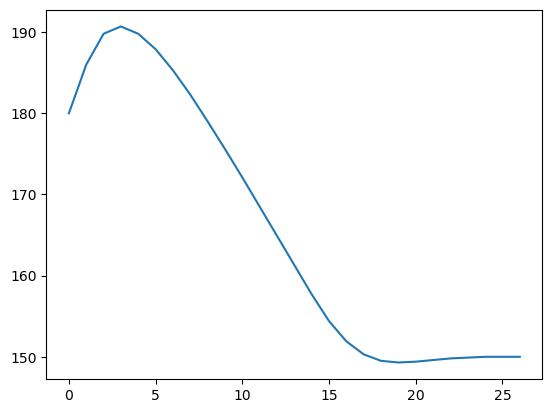

In [411]:
plt.plot(lmpc_data.to_dataframe()["h"][:40])

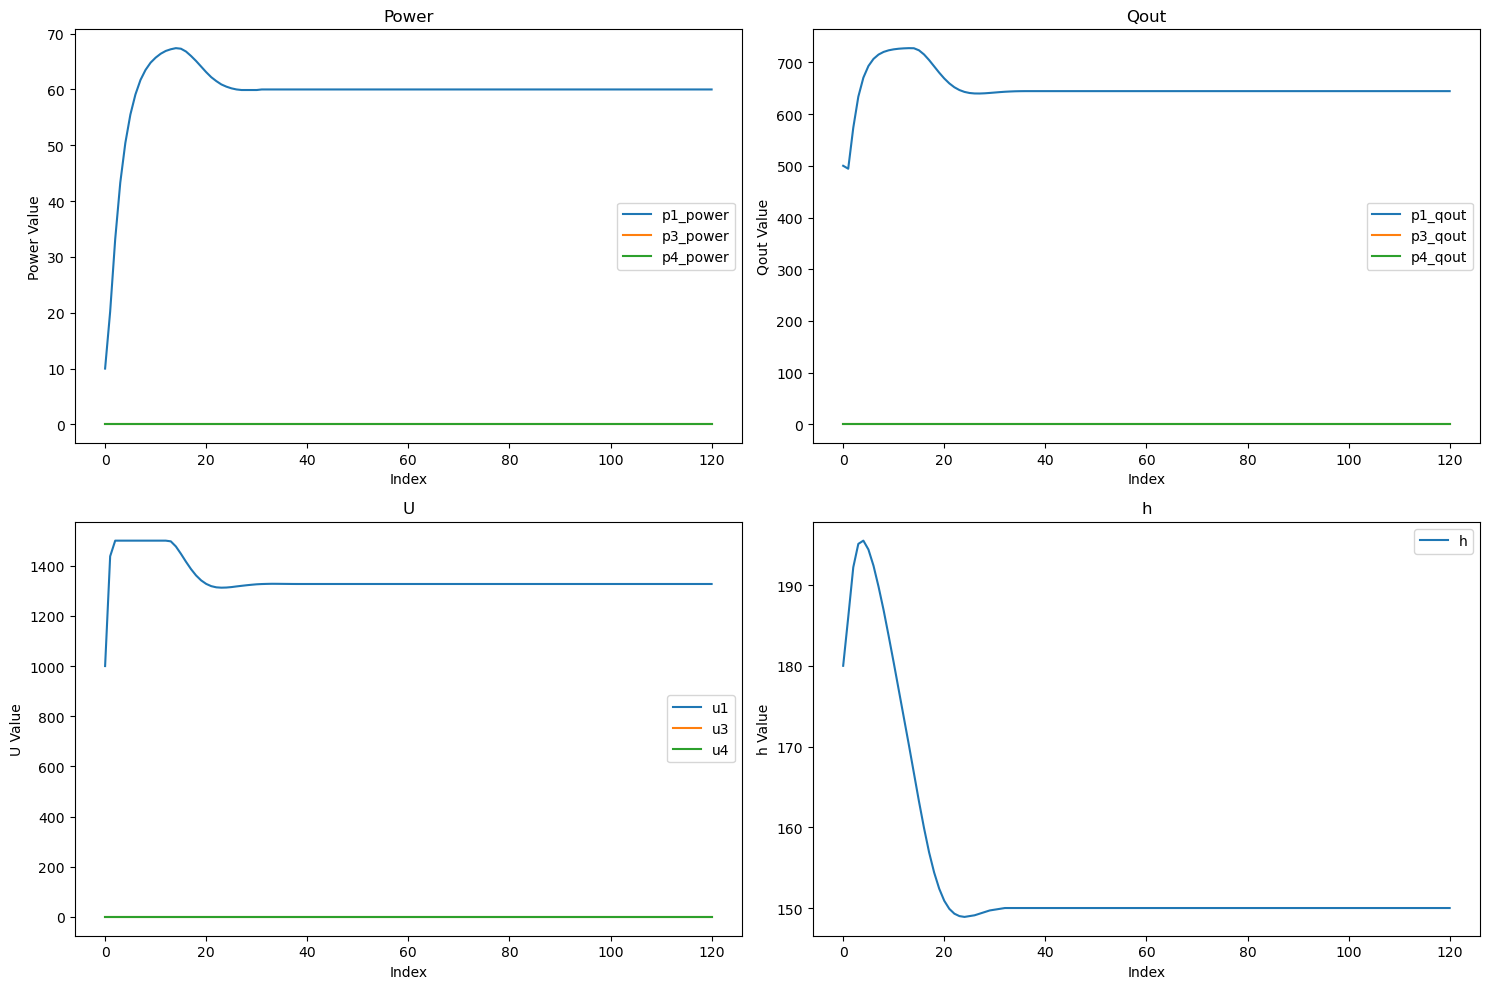

In [319]:
import matplotlib.pyplot as plt
df = lmpc_data.to_dataframe()
# Group columns
powers = ['p1_power', 'p3_power', 'p4_power']
qouts  = ['p1_qout',  'p3_qout',  'p4_qout']
us     = ['u1',       'u3',       'u4']
h      = ['h']

# Setup a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Plot powers
for col in powers:
    axs[0,0].plot(df[col].to_numpy(), label=col)
axs[0,0].set_title("Power")
axs[0,0].set_xlabel("Index")
axs[0,0].set_ylabel("Power Value")
axs[0,0].legend()

# Plot qouts
for col in qouts:
    axs[0,1].plot(df[col].to_numpy(), label=col)
axs[0,1].set_title("Qout")
axs[0,1].set_xlabel("Index")
axs[0,1].set_ylabel("Qout Value")
axs[0,1].legend()

# Plot us
for col in us:
    axs[1,0].plot(df[col].to_numpy(), label=col)
axs[1,0].set_title("U")
axs[1,0].set_xlabel("Index")
axs[1,0].set_ylabel("U Value")
axs[1,0].legend()

# Plot h
axs[1,1].plot(df[h[0]].to_numpy(), label='h')
axs[1,1].set_title("h")
axs[1,1].set_xlabel("Index")
axs[1,1].set_ylabel("h Value")
axs[1,1].legend()

plt.tight_layout()
plt.show()